In [1]:
import pandas as pd
import yfinance as yf 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
import os 

In [2]:
# Manual inputs
TIMEFRAME = "1d"
LOOKBACK_PERIOD = "2y"

# Preprocessing:

In [3]:
# Get the list of S&P500 stocks from Wikipedia
URL = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500 = pd.read_html(URL)
tickers = sp500[0]['Symbol'].to_list()
print(tickers)

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BK', 'BBWI', 'BAX', 'BDX', 'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CF', 'CHRW', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'CVS', 'DH

In [4]:
tickers = ['SPY'] + tickers # Add SPY to the list of tickers, will be used as a benchmark

In [5]:
_universe_stocks = [] # List of series
cached_returns = {} # Dictionary of dataframes
sma200 = {} # Dictionary of 200 day moving averages
sma50 = {} # Dictionary of 50 day moving averages

for stock in tickers:
  data = yf.Ticker(stock).history(period=LOOKBACK_PERIOD, interval=TIMEFRAME) 
  cached_returns[stock] = data
  data["returns"] =  np.log(1+data["Close"].pct_change())
  data.rename(columns={"returns": stock}, inplace=True)

  # Calculate the 200 day moving average
  data['200d'] = data['Close'].rolling(window=200).mean()
  sma200[stock] = data['200d']

  # Calculate the 50 day moving average
  data['50d'] = data['Close'].rolling(window=50).mean()
  sma50[stock] = data['50d']

  # len(date) > 0 and "filter condition" is met;
  #   where "filter condition" is when sma50 > sma200
  if len(data) > 0 and sma50[stock][-1] > sma200[stock][-1]:
    _universe_stocks.append(data[stock])

ERROR BRK.B: No data found, symbol may be delisted
ERROR BF.B: No price data found, symbol may be delisted (period=2y)


In [6]:
universe_stocks = [] # List of series (After applying filter(s))
er_stocks = {} # Dictionary of expected returns

# drift = mean - 0.5 * variance; for sorting 
for e in _universe_stocks:
    try:
        _drift = e[-200:].mean() - 0.5 * e[-200:].var()
        _er = (1+_drift)**252 - 1
        universe_stocks.append(e.name)
        er_stocks[e.name] = _er
    except:
        print("Count not calculate drift for", e.name)

In [7]:
# Drop stocks that don't have the same length as SPY because of potential missing data
len_spy = len(cached_returns["SPY"])
for e in universe_stocks:
    if len(cached_returns[e]) != len_spy:
        print("Removing", e, "from universe")
        universe_stocks.remove(e)

Removing GEHC from universe


### Analysis: Market beta vs Market correlation

In [8]:

def calc_beta(stock, benchmark="SPY"): 

    # Get the historical closes
    try:
        stock_hc = cached_returns[stock]
    except KeyError:
        stock_hc = yf.Ticker(stock).history(period=LOOKBACK_PERIOD)
        cached_returns[stock] = stock_hc

    try: 
        benchmark_hc = cached_returns[benchmark]
    except KeyError:
        benchmark_hc = yf.Ticker(benchmark).history(period=LOOKBACK_PERIOD)
        cached_returns[benchmark] = benchmark_hc

    # Calculate the daily returns for the stock and SPY
    universe_stocks = stock_hc['Close'].pct_change()
    SPY_returns = benchmark_hc['Close'].pct_change()

    # Calculate the beta of the stock against SPY
    covar = universe_stocks.cov(SPY_returns)
    var = SPY_returns.var()

    return covar / var # beta

In [9]:
# Calc the beta in each of the stock in universe_stocks
beta_map = {}
for stock in universe_stocks:
    beta_map[stock] = calc_beta(stock)

In [10]:
# Construct a correlation matrix
correl_matrix = {}
for stock in universe_stocks:
    correl_matrix[stock] = {}
    for other_stock in universe_stocks:
        correl_matrix[stock][other_stock] = cached_returns[stock]["Close"].corr(cached_returns[other_stock]["Close"])

# Calc the correlation of each stock with SPY
correl_with_SPY_map = {}
for stock in universe_stocks:
    correl_with_SPY_map[stock] = correl_matrix[stock]["SPY"]

# Classical Machine Learning:


Applying k-means clustering to segment the stocks into different groups

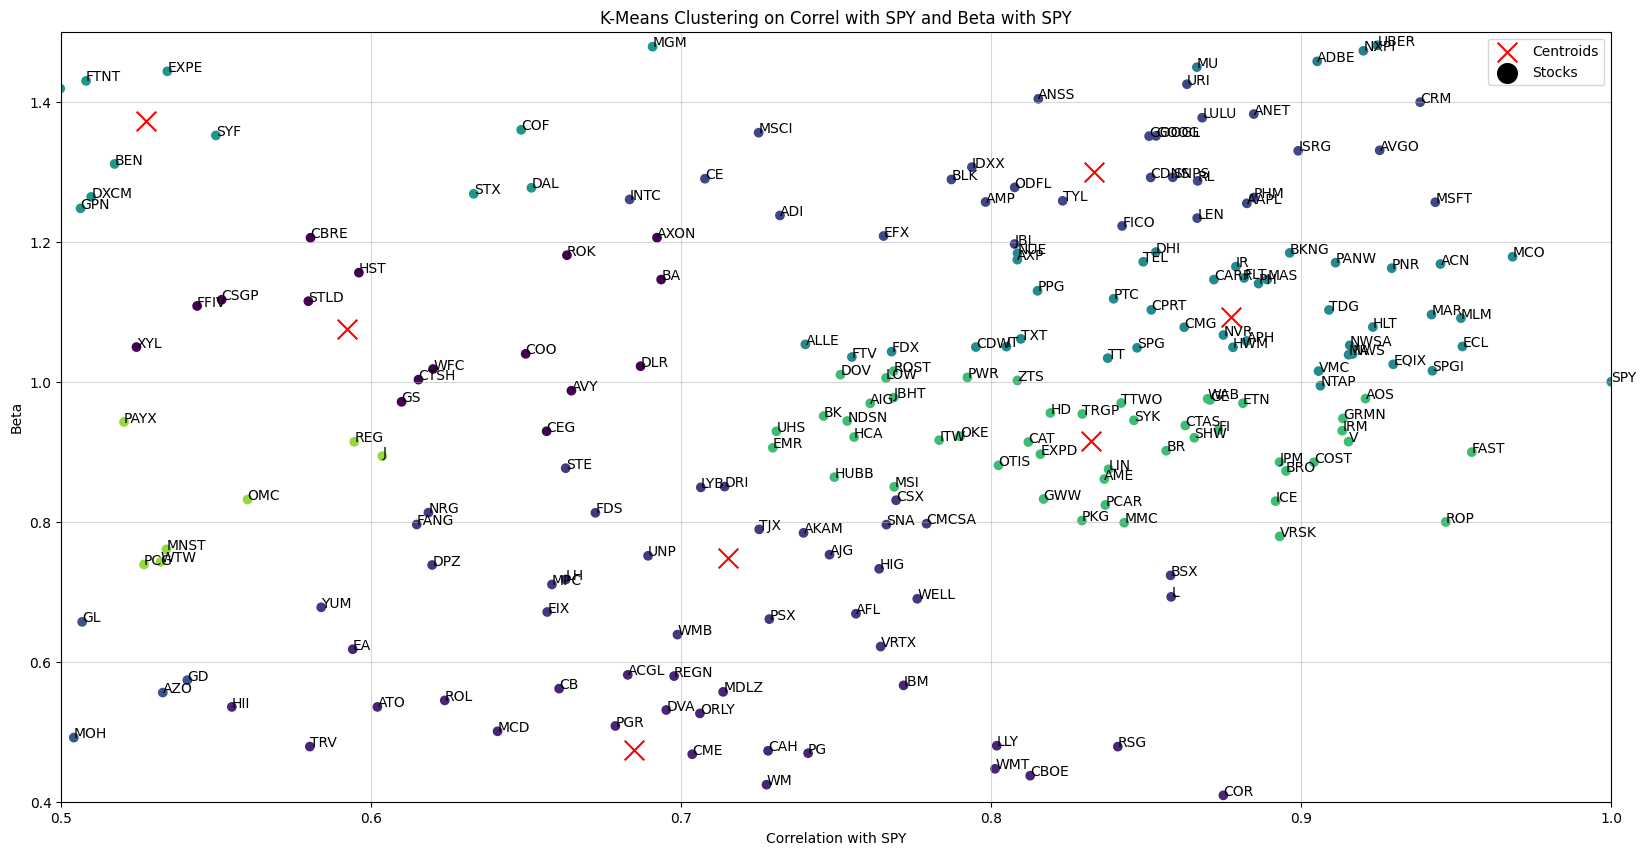

In [11]:

N_CLUSTERS = 20

# Features
X = pd.DataFrame(list(zip(correl_with_SPY_map.values(), beta_map.values())), columns=["Correl", "Beta"])

kmeans = KMeans(n_clusters=N_CLUSTERS)
kmeans.fit(X)
clusters = kmeans.predict(X)

X["Cluster"] = clusters # Add the clusters to the dataframe

# Plot the clusters
plt.figure(figsize=(20, 10))
plt.scatter(X["Correl"], X["Beta"], c=X["Cluster"], cmap="viridis")
plt.xlabel("Correlation with SPY"), plt.ylabel("Beta")
plt.title("K-Means Clustering on Correl with SPY and Beta with SPY")
plt.grid(alpha=0.5)

# Add labels to each point
for label, correl in correl_with_SPY_map.items():
    beta = beta_map[label]
    plt.annotate(label, (correl, beta))

# Add the centroids to the plot
centroids = kmeans.cluster_centers_ 
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=200, c="red")

# Legend
plt.scatter([], [], marker="x", s=200, color="red", label="Centroids")
plt.scatter([], [], marker="o", s=200, color="black", label="Stocks")
plt.legend()


# Zoom in to not show outliers
plt.ylim(0.4, 1.5)
plt.xlim(0.5, 1)

plt.show()

In [12]:
# Dataframe with rows: stock name, cluster number
cluster_map = pd.DataFrame()
cluster_map['data_index'] = X.index.values
cluster_map['cluster'] = kmeans.labels_
cluster_map['Ticker'] = list(correl_with_SPY_map.keys())

In [13]:
def clean_data(cluster_map):
    # Sort by column: 'cluster' (ascending)
    cluster_map = cluster_map.sort_values(['cluster'])
    return cluster_map

cluster_map_clean = clean_data(cluster_map.copy())

# Append the drifts to the dataframe
cluster_map_clean["E(r)"] = cluster_map_clean["Ticker"].map(er_stocks)

# Sorting by drift, then by cluster
cluster_map_clean = cluster_map_clean.sort_values(["E(r)"], ascending=False)


cluster_map_clean.head()

,data_index,cluster,Ticker,E(r)
261,261,15,NVDA,2.156220
55,55,4,AVGO,1.399967
232,232,8,META,1.385217
353,353,8,UBER,1.293356
356,356,4,URI,1.282843


In [14]:
# Save the dataframe to a CSV file
cluster_map_clean.to_csv(os.path.join(os.getcwd(), "tmp_cluster_map.csv"))
os.system("open tmp_cluster_map.csv")

0

In [15]:
dict_cluster_ticker = {}
for i in range(N_CLUSTERS):
    dict_cluster_ticker[i] = cluster_map_clean[cluster_map_clean['cluster'] == i]['Ticker'].to_list()

# Print the stocks in each cluster
for i in range(N_CLUSTERS):
    print("cluster_{}".format(i), "=", dict_cluster_ticker[i])

cluster_0 = ['CEG', 'WFC', 'DLR', 'RJF', 'AXON', 'FFIV', 'STLD', 'CTSH', 'AVY', 'C', 'GS', 'CBRE', 'HST', 'XYL', 'CSGP', 'PLD', 'ROK', 'BA', 'COO']
cluster_1 = ['MTB', 'LUV', 'SYY', 'AMT', 'MMM', 'DLTR', 'CCI', 'AMCR', 'EXR', 'IFF', 'SBAC', 'PEAK', 'RMD']
cluster_2 = ['LLY', 'IBM', 'HII', 'CBOE', 'COR', 'PGR', 'REGN', 'MCK', 'CAH', 'CB', 'RSG', 'ABBV', 'WM', 'CME', 'TRV', 'DVA', 'AMGN', 'WMT', 'ORLY', 'EA', 'ACGL', 'MRK', 'CL', 'PG', 'CHD', 'MCD', 'ROL', 'ATO', 'MDLZ']
cluster_3 = ['NRG', 'PSX', 'MPC', 'DPZ', 'HIG', 'FANG', 'TJX', 'L', 'UNP', 'AKAM', 'WMB', 'BSX', 'STE', 'AFL', 'VRTX', 'CSX', 'WELL', 'DRI', 'FDS', 'LH', 'LYB', 'AJG', 'SNA', 'CMCSA', 'YUM', 'EIX']
cluster_4 = ['AVGO', 'URI', 'ANET', 'JBL', 'FICO', 'RL', 'PHM', 'SNPS', 'CE', 'CRM', 'CDNS', 'AMP', 'ODFL', 'INTC', 'LEN', 'MSFT', 'EFX', 'BLK', 'ISRG', 'GOOG', 'GOOGL', 'LULU', 'MSCI', 'IDXX', 'ANSS', 'TYL', 'AAPL', 'ADI']
cluster_5 = ['LDOS', 'WRB', 'AIZ', 'ALL', 'MOH', 'GD', 'VLO', 'CI', 'GL', 'TMUS', 'PXD', 'COP', 'KMI', '

# Others

In [39]:
crnt_portfolio = ["AAPL", "ABNB", "ABT", "AMZN", "CBOE", "ECL", "GE", "GOOGL", "KO", "META", "MMC", "MRK", "SPY", "TRGP", "VRTX", "WDC", "WFC"]
# to_dispose = tickers in crnt_portfolio but not in universe_stocks 
to_dispose = [e for e in crnt_portfolio if e not in universe_stocks]
print("Stocks to dispose:", to_dispose)

Stocks to dispose: []


In [40]:
# Clusters that are not in current portfolio
clusters_to_add = [cluster_map_clean[cluster_map_clean['Ticker'] == e]['cluster'].values[0] for e in crnt_portfolio if e in universe_stocks]
clusters_not_in_portfolio = [e for e in range(N_CLUSTERS) if e not in clusters_to_add]
print("Clusters not in portfolio:", clusters_not_in_portfolio)

# Export the watchlist to a text file (TradingView format; for import to watchlist)
yyyymmdd = pd.Timestamp.now().strftime("%Y%m%d")
with open("new_stocks_watchlist{}.txt".format(yyyymmdd), "w") as f:
    for i in clusters_not_in_portfolio:
        f.write("###CLUSTER {}\n".format(i))
        for stock in dict_cluster_ticker[i]:
            f.write(stock + "\n")
        f.write("\n")



Clusters not in portfolio: [1, 5, 7, 11, 12, 14, 17, 18, 19]


In [41]:
# Adding new stocks to the portfolio
crnt_portfolio += ["LDOS", "CF", "USB", "CTLT", "CNC", "BBWI", "WRK", "ZION", "MTB"]

# Assert no duplicated elements in crnt_portfolio
assert len(crnt_portfolio) == len(set(crnt_portfolio)), "Duplicated elements in crnt_portfolio"

# "To apply MPT <'Part 2'>:"
print(str(crnt_portfolio))

['AAPL', 'ABNB', 'ABT', 'AMZN', 'CBOE', 'ECL', 'GE', 'GOOGL', 'KO', 'META', 'MMC', 'MRK', 'SPY', 'TRGP', 'VRTX', 'WDC', 'WFC', 'LDOS', 'CF', 'USB', 'CTLT', 'CNC', 'BBWI', 'WRK', 'ZION', 'MTB']
